# Introduction and Environment Setup

The advent of powerful Large Language Models (LLMs) has fundamentally altered the landscape of artificial intelligence applications.

The primary interface for these models is natural language, making the skill of crafting effective inputs—a discipline known as **prompt engineering**—a critical component for developers and researchers.

Prompt engineering is not merely the act of asking a question; it is the science of designing and optimizing prompts to guide LLMs toward desired outcomes with precision, reliability, and efficiency.

As models grow in capability, the sophistication of interaction methods must evolve in parallel.

Simple instructions suffice for simple tasks, but unlocking the full potential for complex reasoning, persona adoption, and interaction with external systems requires a more advanced approach.

## Setup your free API Key using Google's AI Studio

https://aistudio.google.com/


### Install necessary libraries

In [ ]:
!pip install --upgrade --quiet langchain-google-genai

In [ ]:
import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI

# Access the API key from Colab Secrets
os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")

# Initialize the model
gemini_client = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

# Now you can use the llm to interact with the model
response = gemini_client.invoke(""" What is the capital of France""")
print(response.content)

# The Anatomy of an Effective Prompt: A Unified Framework

A fundamental advancement in prompt engineering is the realization that a prompt is not a monolithic question but a structured document composed of distinct components.



- **Role (or Persona):** This component defines who the model should be. Assigning a role, such as "You are a senior technical support specialist," constrains the model's vast knowledge base, forcing it to filter its response through a specific lens of expertise, tone, and style. This dramatically improves the coherence and domain-specificity of the output.


- **Context (or Background Information):** This provides the necessary background for the task. It can include user history, product documentation, previous conversation turns, or any other data that informs the query. Providing rich context is essential for generating relevant and personalized responses.


- **Task (or Instruction/Directive):** This is the core of the prompt—a clear, specific, and unambiguous statement of the action the model should perform. The use of direct action verbs (e.g., "Analyze," "Summarize," "Generate," "Classify") is critical for clarity.


- **Examples (or Shots):** These are high-quality examples of the desired input-output pattern. They are the foundation of few-shot prompting and are one of the most powerful tools for controlling output format and style. By showing the model exactly what is expected, examples enable a form of in-context learning.


- **Constraints (or Rules/Warnings):** This component defines the boundaries for the response. It specifies what the model should not do, such as avoiding certain topics, adhering to a word count, or refraining from using technical jargon. These "guardrails" are crucial for safety and brand alignment.


- **Output Format (or Structure):** This explicitly defines the structure of the desired output, such as JSON, Markdown, or a bulleted list. Specifying the format is vital for applications that need to programmatically parse the model's response, as it ensures the output is machine-readable and consistent.

To help the model distinguish between these different components, it is a best practice to use clear delimiters. Structuring the prompt with markers like Markdown headers (e.g., `###Instruction###`).

# Let's talk about RAG, now

# Our Approach

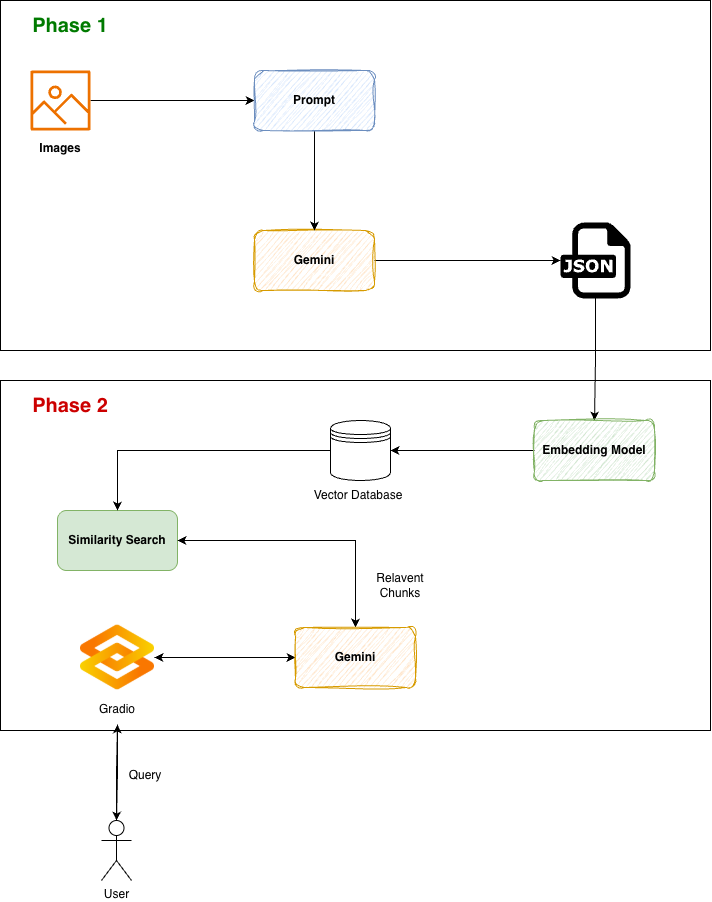

## The prompt

In [ ]:
image_description_prompt = """
**Role:**
You are an expert Computer Vision Metadata Specialist and SEO Archivist. You possess a deep understanding of visual semantics, image indexing, and natural language retrieval. Your capability involves translating visual data into precise, machine-readable text optimized for search algorithms.

**Context:**
We are building a high-performance multimodal search engine. The metadata you generate will be used to populate a vector database, allowing users to find images using both specific keyword matching and semantic natural language queries (e.g., "a quiet place to work with coffee"). High accuracy and descriptive depth are required to distinguish between similar images.

**Task:**
Analyze the provided image and generate a structured JSON object containing detailed metadata. You must extract the main subject, describe the scene atmospherics, identify visual elements, transcribe specific text, and generate search-optimized keywords.

**Constraints:**

1.  **Description:** Must be objective and factual. Limit to 2-3 sentences. Focus on action, lighting, and mood.
2.  **Text Content:** If no text is visible, return `null`. If text is visible, transcribe it exactly as it appears, preserving case where possible.
3.  **Keywords:** Provide exactly 10-15 keywords. Mix broad concepts (e.g., "urban," "melancholy") with specific objects (e.g., "red umbrella," "taxi").
4.  **Safety:** Do not generate content that violates safety policies. If the image is unclear or blurry, note this in the description.
5.  **Format:** The output must be raw JSON only. Do not include markdown formatting (like ` json ...  `) or conversational filler.

**Examples:**

*Input:* [An image of a golden retriever catching a frisbee in a park on a sunny day]

*Output:*

```json
{
  "main_subject": "Golden Retriever dog",
  "detailed_description": "A golden retriever leaps into the air to catch a red frisbee against a clear blue sky. The lighting is bright and natural, casting sharp shadows on the green grass below. The mood is energetic and playful.",
  "visual_elements": [
    "Golden Retriever",
    "Red Frisbee",
    "Green Grass",
    "Blue Sky",
    "Motion Blur"
  ],
  "text_content": null,
  "search_keywords": [
    "dog",
    "pet",
    "playing",
    "fetch",
    "frisbee",
    "park",
    "sunny",
    "action shot",
    "canine",
    "jumping",
    "outdoor",
    "joyful",
    "golden retriever",
    "summer"
  ]
}
```

**Output Format:**
Generate the response in the following JSON structure:

```json
{
  "main_subject": "String",
  "detailed_description": "String",
  "visual_elements": ["String", "String"],
  "text_content": "String or null",
  "search_keywords": ["String", "String"]
}
```
"""

# Processing One Image

In [ ]:
import os
import base64
import mimetypes
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage

# 1. Setup
os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")

# Initialize the model
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.2
)

# 2. Helper function to encode image to Base64
def encode_image(image_path):
    """Encodes a local image to base64 string."""
    # https://en.wikipedia.org/wiki/Base64
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# 3. The Metadata Function
def generate_search_metadata(image_path, llm, prompt_text):
    """
    Generates a detailed description using LangChain and Gemini.
    """
    try:
        # Determine mime type (e.g., 'image/jpeg', 'image/png')
        mime_type, _ = mimetypes.guess_type(image_path)
        if not mime_type:
            mime_type = 'image/jpeg' # Default fallback

        # Get Base64 string
        img_base64 = encode_image(image_path)

        # Create the Multimodal Message
        # LangChain expects a list of dictionaries for multimodal content
        message = HumanMessage(
            content=[
                {"type": "text", "text": prompt_text},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:{mime_type};base64,{img_base64}"}
                }
            ]
        )

        # Invoke the LLM
        response = llm.invoke([message])

        return response.content.replace('```json', '').replace('```', '')

    except FileNotFoundError:
        print(f"Error: The file at {image_path} was not found.")
        return None
    except Exception as e:
        print(f"An error occurred during generation: {e}")
        return None

In [ ]:
from google.colab import drive # use this code to connect to the drive
drive.mount('/content/drive')

In [ ]:
image_path = "/content/drive/MyDrive/images/IMG_0572.JPG"

# Run the function
metadata = generate_search_metadata(image_path, llm, image_description_prompt)

if metadata:
    print(metadata)

# Processing All Images

In [ ]:
import os
import json

source_folder = "/content/drive/MyDrive/images/"
output_folder = "/content/drive/MyDrive/jsons/"

os.makedirs(output_folder, exist_ok=True)

# Supported image extensions to filter for
valid_extensions = ('.jpg', '.jpeg', '.png', '.webp', '.heic')

print(f"Starting processing for images in: {source_folder}\n")

files = os.listdir(source_folder)
# Calculate total relevant files for the progress counter
total_files = len([f for f in files if f.lower().endswith(valid_extensions)])
processed_count = 0

for filename in files:
    if filename.lower().endswith(valid_extensions):

        image_path = os.path.join(source_folder, filename)

        # Define the output JSON path (same name as image, but .json extension)
        json_filename = f"{os.path.splitext(filename)[0]}.json"
        json_path = os.path.join(output_folder, json_filename)

        if os.path.exists(json_path):
            print(f"[{processed_count + 1}/{total_files}] Skipping: {filename} (JSON already exists)")
            processed_count += 1
            continue

        print(f"[{processed_count + 1}/{total_files}] Generating metadata for: {filename}...")

        try:
            # Call your existing function
            description = generate_search_metadata(image_path, llm, image_description_prompt)

            # Ensure description is parsed to dict if returned as string
            if isinstance(description, str):
                description = json.loads(description)

            if description:
                # Prepare the data structure
                data = {
                    "file_path": image_path,
                    "description": description
                }

                # Write to JSON file
                with open(json_path, 'w', encoding='utf-8') as json_file:
                    json.dump(data, json_file, indent=4)

                print(f"   -> Saved to {json_filename}")
            else:
                print(f"   -> Skipped {filename} (Generation returned empty)")

        except Exception as e:
            print(f"   -> Error processing {filename}: {e}")

        processed_count += 1

print("\n--- Processing Complete ---")

# Creating Embeddings

In [ ]:
!pip install -U -q langchain-google-genai langchain-chroma chromadb

In [ ]:
import os
import json
import time
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.documents import Document
from google.colab import userdata

# 1. Setup
os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
json_folder = "/content/drive/MyDrive/jsons"
db_path = "/content/drive/MyDrive/chroma_db"

# Initialize Embeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

# 2. Check if DB exists before doing heavy lifting
# We check if the folder exists and is not empty (Chroma creates files inside)
db_exists = os.path.exists(db_path) and os.listdir(db_path)

if db_exists:
    print(f"Database found at {db_path}. Loading existing VectorStore...")
    vectorstore = Chroma(
        persist_directory=db_path,
        embedding_function=embeddings
    )
    print(f"Loaded existing DB with {vectorstore._collection.count()} documents.")

else:
    print("Database not found. Starting ingestion process...")

    # Load ALL JSONs into a list of Documents first (No API calls here)
    documents = []

    if os.path.exists(json_folder):
        files = [f for f in os.listdir(json_folder) if f.endswith('.json')]
        print(f"Found {len(files)} JSON files. Preparing data...")

        for filename in files:
            file_path = os.path.join(json_folder, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                desc_obj = data.get("description", {})

                # Construct Context
                text_content = f"""
                Subject: {desc_obj.get('main_subject', 'Unknown')}
                Description: {desc_obj.get('detailed_description', '')}
                Keywords: {', '.join(desc_obj.get('search_keywords', []))}
                Visual Elements: {', '.join(desc_obj.get('visual_elements', []))}
                """

                doc = Document(
                    page_content=text_content,
                    metadata={
                        "file_name": data.get("file_name", filename),
                        "file_path": data.get("file_path", "")
                    }
                )
                documents.append(doc)
    else:
        print("JSON folder not found.")

    # 3. Add to Chroma in Batches with Timeout
    if documents:
        print(f"Loaded {len(documents)} documents. Starting ingestion with rate limits...")

        # Initialize the DB (This creates the folder)
        vectorstore = Chroma(
            persist_directory=db_path,
            embedding_function=embeddings
        )

        BATCH_SIZE = 5
        total_batches = (len(documents) + BATCH_SIZE - 1) // BATCH_SIZE

        for i in range(0, len(documents), BATCH_SIZE):
            batch = documents[i : i + BATCH_SIZE]
            current_batch_num = (i // BATCH_SIZE) + 1

            print(f"Processing Batch {current_batch_num}/{total_batches} ({len(batch)} docs)...")

            # A. Add documents (This triggers the API Call)
            vectorstore.add_documents(batch)

            # B. Wait if this is not the last batch
            if i + BATCH_SIZE < len(documents):
                print("   -> Waiting 60 seconds to respect rate limits...")
                time.sleep(60)

        print(f"\nSuccess! All documents saved to: {db_path}")

    else:
        print("No documents to process.")

In [ ]:
import os
from langchain_chroma import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from google.colab import userdata
from IPython.display import display, Image


db_path = "/content/drive/MyDrive/chroma_db"

# IMPORTANT: Must use the exact same model name you used to create the DB
embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

# Load the Database
# We point to the persist_directory to load the existing index
vectorstore = Chroma(
    persist_directory=db_path,
    embedding_function=embeddings
)

print("Database loaded successfully!")

def search_images(query, top_k=3):
    """
    Searches the vector DB for images matching the text query.
    """

    # Perform Similarity Search
    # This embeds the query and finds the 'top_k' closest vectors
    results = vectorstore.similarity_search(query, k=top_k)

    if not results:
        print("No matches found.")
        return

    # Display Results
    for i, doc in enumerate(results):
        file_path = doc.metadata.get("file_path")
        subject = doc.metadata.get("main_subject")
        file_name = doc.metadata.get("file_name")

        print(f"Match #{i+1}")
        print(f"File: {file_name}")
        print(f"Context: {doc.page_content[:100]}...") # Show first 100 chars of description

        # Display the actual image
        if os.path.exists(file_path):
            display(Image(filename=file_path, width=300))
        else:
            print(f"Image file not found at: {file_path}")

        print("-" * 40)


# Example 1: Conceptual search
search_images("data science")